<a href="https://colab.research.google.com/github/parment1/Project-M1-M2/blob/main/Module_1_%26_2_30092021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [258]:
import pandas as pd
import os
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import statsmodels.api as sm
from functools import reduce
from pandas.tseries.offsets import MonthEnd  
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import anderson
from scipy.stats import shapiro
from scipy.stats import normaltest
from sklearn.linear_model import LinearRegression
from numpy import log
 

pd.set_option('display.max_rows',300)


Part I : Data acquisition, formating and cleaning

PART I project: Data acquisition, formating and cleaning

Dataset 1: Download the time series available on NASDAQ website for the Nasdaq Composite index, max history 2011 https://www.nasdaq.com/market-activity/index/ndx/historical

Dataset 2:

-GDP: We use GGP in percent change from preceding Period, quarterly, Seasonally Adjusted Annual Rate: Source: https://fred.stlouisfed.org/tags/series?t=quarterly

-CPI (consumer price inflation): Consumer Price Index: Growth Rate Same Period Previous Year, Monthly, Not Seasonally Adjusted. Source: https://fred.stlouisfed.org/tags/series?t=quarterly

-US Interest rates: Effective Federal Funds Rates/FEDFUNDS

-US Unemployment rate Unemployment Rate, Percentfed.org/series/UNRATE

Problem: Do we see a relationship between the stock market and macroeconomic variables


In [259]:
#Open each xls/csv
Nasdaq = pd.read_excel('/content/Nasdaq composite index.xlsx')
#CPI = Consumer price index
CPI = pd.read_excel('/content/CPI monthly.xls')
#Interest_rate = fed fund rate
Interest_rate = pd.read_excel('/content/Fed fund.xls')
GDP = pd.read_excel('/content/GDP.xls')
Unemployment = pd.read_excel('/content/Unemployment.xls')


Explore the strucutre of the different datasets. They all have different shape with monthly data for Unemployment CPI and interest rate, daily for Nasdaq and quarterly for GDP.

We add the monthly percentage change of the Nasdaq



In [260]:
#check size of each dataset
print([Nasdaq.shape,CPI.shape,Interest_rate.shape,GDP.shape,Unemployment.shape])

[(2557, 6), (464, 2), (806, 2), (297, 2), (884, 2)]


In [261]:
#Align the column name for all data set
Nasdaq = Nasdaq.rename(columns={'Date': 'observation_date'})

#Select columns Date & Close/Last date from Nasdaq dataset
Nasdaq = Nasdaq[['observation_date','Close/Last']]
Nasdaq = Nasdaq.iloc[::-1].reset_index(drop=True)

#Get only monthly value for nadsqa (we can use either last day or first day of the month, need to be a trading day)
dates_month = pd.bdate_range(Nasdaq['observation_date'].min(), Nasdaq['observation_date'].max(), freq='1MS')

#Apply bdate range to the Nasdaq DF using isin
Nasdaq_mth = Nasdaq[Nasdaq['observation_date'].isin(dates_month)]
Nasdaq_mth.reset_index(inplace=True,drop=True)

#Calculate monthly return for the Nasdaq timeserie
Nasdaq_mth['Monthly return'] =  Nasdaq_mth['Close/Last'].pct_change()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


Each dataset has a column "observation_date", with a different length. The maximum time length publicly available for download is 10 years, we do the following steps

1. we adjust the other data frame to this timeframe for each DF, we set up the end date at end 2019
2. Check the new shape of each DF
3. Merge the different DF into one
4. Simplify the name of the columns

In [262]:
#Select observation period, adjust starting/ending value for different periods

starting_date = '2012-01-01'
ending_date = '2020-06-01'

#Function to select obeservation period, df = dataframe

def select_date(df):
  x = df[(df['observation_date'] >= starting_date) & (df['observation_date'] <= ending_date)]
  x.reset_index(inplace=True,drop=True)
  return x

#Apply to the different dataframe using pipe and create new DF with selected time period
Nasdaq_sample, Interest_rate_sample, CPI_sample, GDP_sample,Unemployment_sample = (df.pipe(select_date)for df in [Nasdaq_mth, Interest_rate,CPI, GDP,Unemployment])


In [263]:
#Check size of dataset after transformation
print([Nasdaq_sample.shape,CPI_sample.shape,Interest_rate_sample.shape,GDP_sample.shape,Unemployment_sample.shape])

[(101, 3), (102, 2), (102, 2), (34, 2), (102, 2)]


In [264]:
data_frames = [Nasdaq_sample,CPI_sample,Interest_rate_sample,Unemployment_sample,GDP_sample]

#Merge all DF into one based on "observation date" using the function melt, keep N/A if any

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['observation_date'],
                                            how='left'), data_frames)

#drop the column Close/Last and set "observation date" as index
df_merged_ = df_merged.drop('Close/Last', axis = 1)
df_merged_clean = df_merged_.set_index('observation_date')

#fillna 
df_merged_clean = df_merged_clean.fillna(method='bfill')

#See column name
columns = df_merged_clean.columns
columns

Index(['Monthly return', 'CPI', 'Effective Federal Funds Rate',
       'Unemployment Rate, Percent', 'Gross Domestic Product'],
      dtype='object')

Text(0.5, 1.0, 'Nasdaq composite index')

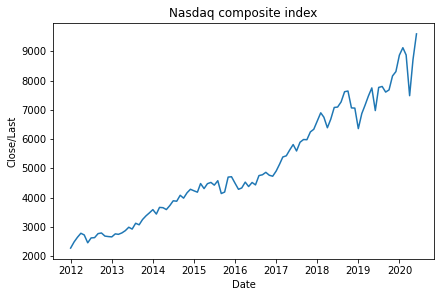

In [265]:
# Line plots
fig1 = plt.figure(figsize=(15, 8))

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 1      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
fig1.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

ax1 = fig1.add_subplot(221)
sns.lineplot(
    data=df_merged, 
#     kind="line",
    x='observation_date', 
    y="Close/Last")
plt.xlabel('Date')
plt.title('Nasdaq composite index')

In [266]:
df_merged_clean.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 101 entries, 2012-01-01 to 2020-06-01
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Monthly return                101 non-null    float64
 1   CPI                           101 non-null    float64
 2   Effective Federal Funds Rate  101 non-null    float64
 3   Unemployment Rate, Percent    101 non-null    float64
 4   Gross Domestic Product        99 non-null     float64
dtypes: float64(5)
memory usage: 4.7 KB


In [267]:
df_merged_clean.isna().sum()


Monthly return                  0
CPI                             0
Effective Federal Funds Rate    0
Unemployment Rate, Percent      0
Gross Domestic Product          2
dtype: int64


Part II: Descriptive analysis

-Check how dataset looks like
-Plot the different dataset
-Correlation matrix
-Cointegration matrix
-Test

Check how the data are distrbitued with  a kernel density estimate to smooth the histogram



In [268]:
df_columns = df_merged_clean.columns
df_merged_clean = df_merged_clean.fillna(method="ffill")
df_merged_clean.tail(10)

,Monthly return,CPI,Effective Federal Funds Rate,"Unemployment Rate, Percent",Gross Domestic Product
observation_date,,,,,
2019-09-01,-0.024566,3.150655,2.04,3.5,3.6
2019-10-01,0.009807,2.702275,1.83,3.6,3.6
2019-11-01,0.062080,2.960686,1.55,3.6,-3.9
2019-12-01,0.018146,1.999222,1.55,3.6,-3.9
2020-01-01,0.067751,2.592215,1.55,3.5,-3.9
2020-02-01,0.028630,2.788786,1.58,3.5,-32.4
2020-03-01,-0.027202,2.576730,0.65,4.4,-32.4
2020-04-01,-0.156758,1.763132,0.05,14.8,-32.4
2020-05-01,0.164553,3.091994,0.05,13.3,-32.4


Text(0.5, 1.0, 'Unemployment rate %')

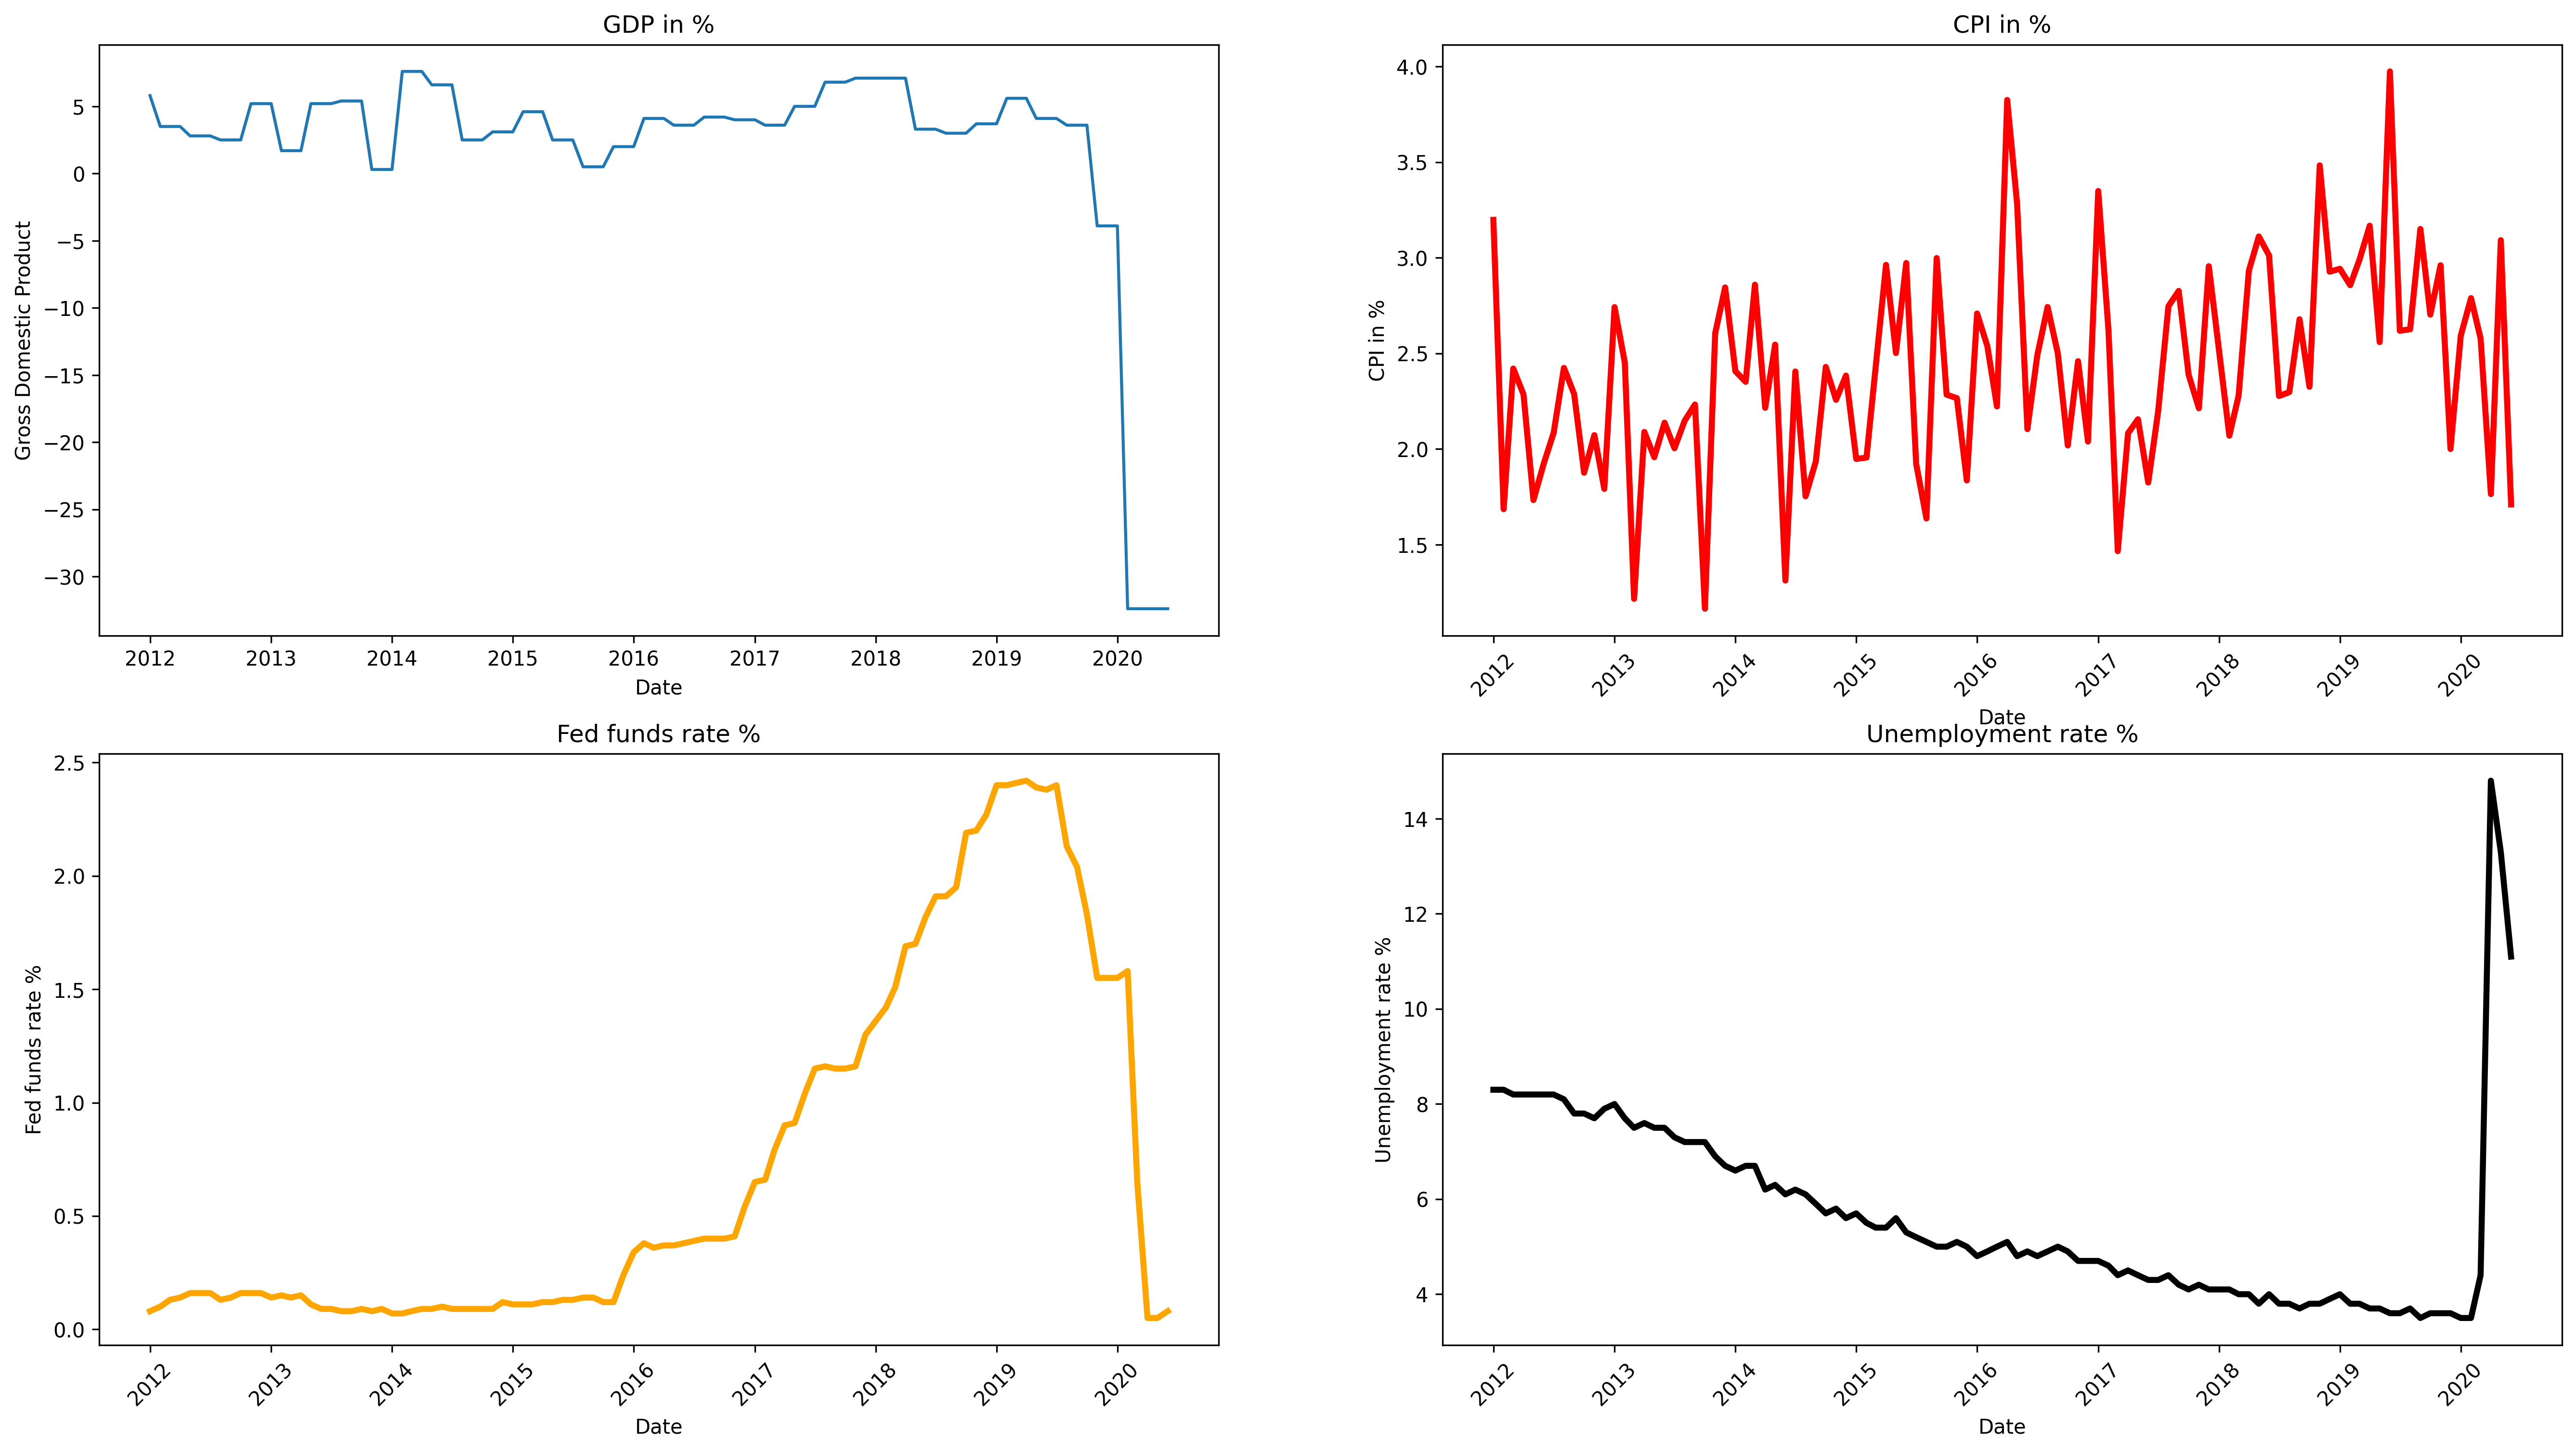

In [269]:
# Line plots
fig1 = plt.figure(figsize=(22, 10),dpi=300)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 1      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
fig1.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

ax1 = fig1.add_subplot(221)
sns.lineplot(
    data=df_merged_clean, 
#     kind="line",
    x=df_merged_clean.index, 
    y="Gross Domestic Product")
plt.xlabel('Date')
plt.title('GDP in %')

ax2 = fig1.add_subplot(222)
sns.lineplot(
    data=df_merged_clean, 
    x=df_merged_clean.index, 
    y="CPI",
    ax = ax2,
    linewidth = 3,
    color = 'red')
plt.xticks(rotation=45) 
plt.ylabel('CPI in %')
plt.xlabel('Date')
plt.title('CPI in %')

ax3 = fig1.add_subplot(223)
sns.lineplot(
    data=df_merged_clean, 
    x=df_merged_clean.index, 
    y="Effective Federal Funds Rate",
    ax = ax3,
    linewidth = 3,
    color = 'orange')
plt.xticks(rotation=45) 
plt.ylabel('Fed funds rate %')
plt.xlabel('Date')
plt.title('Fed funds rate %')

ax4 = fig1.add_subplot(224)
sns.lineplot(
    data=df_merged_clean, 
    x=df_merged_clean.index, 
    y="Unemployment Rate, Percent",
    ax = ax4,
    linewidth = 3,
    color = 'black')
plt.xticks(rotation=45) 
plt.ylabel('Unemployment rate %')
plt.xlabel('Date')
plt.title('Unemployment rate %')



Text(0.5, 1.0, 'Unemployment rate %')

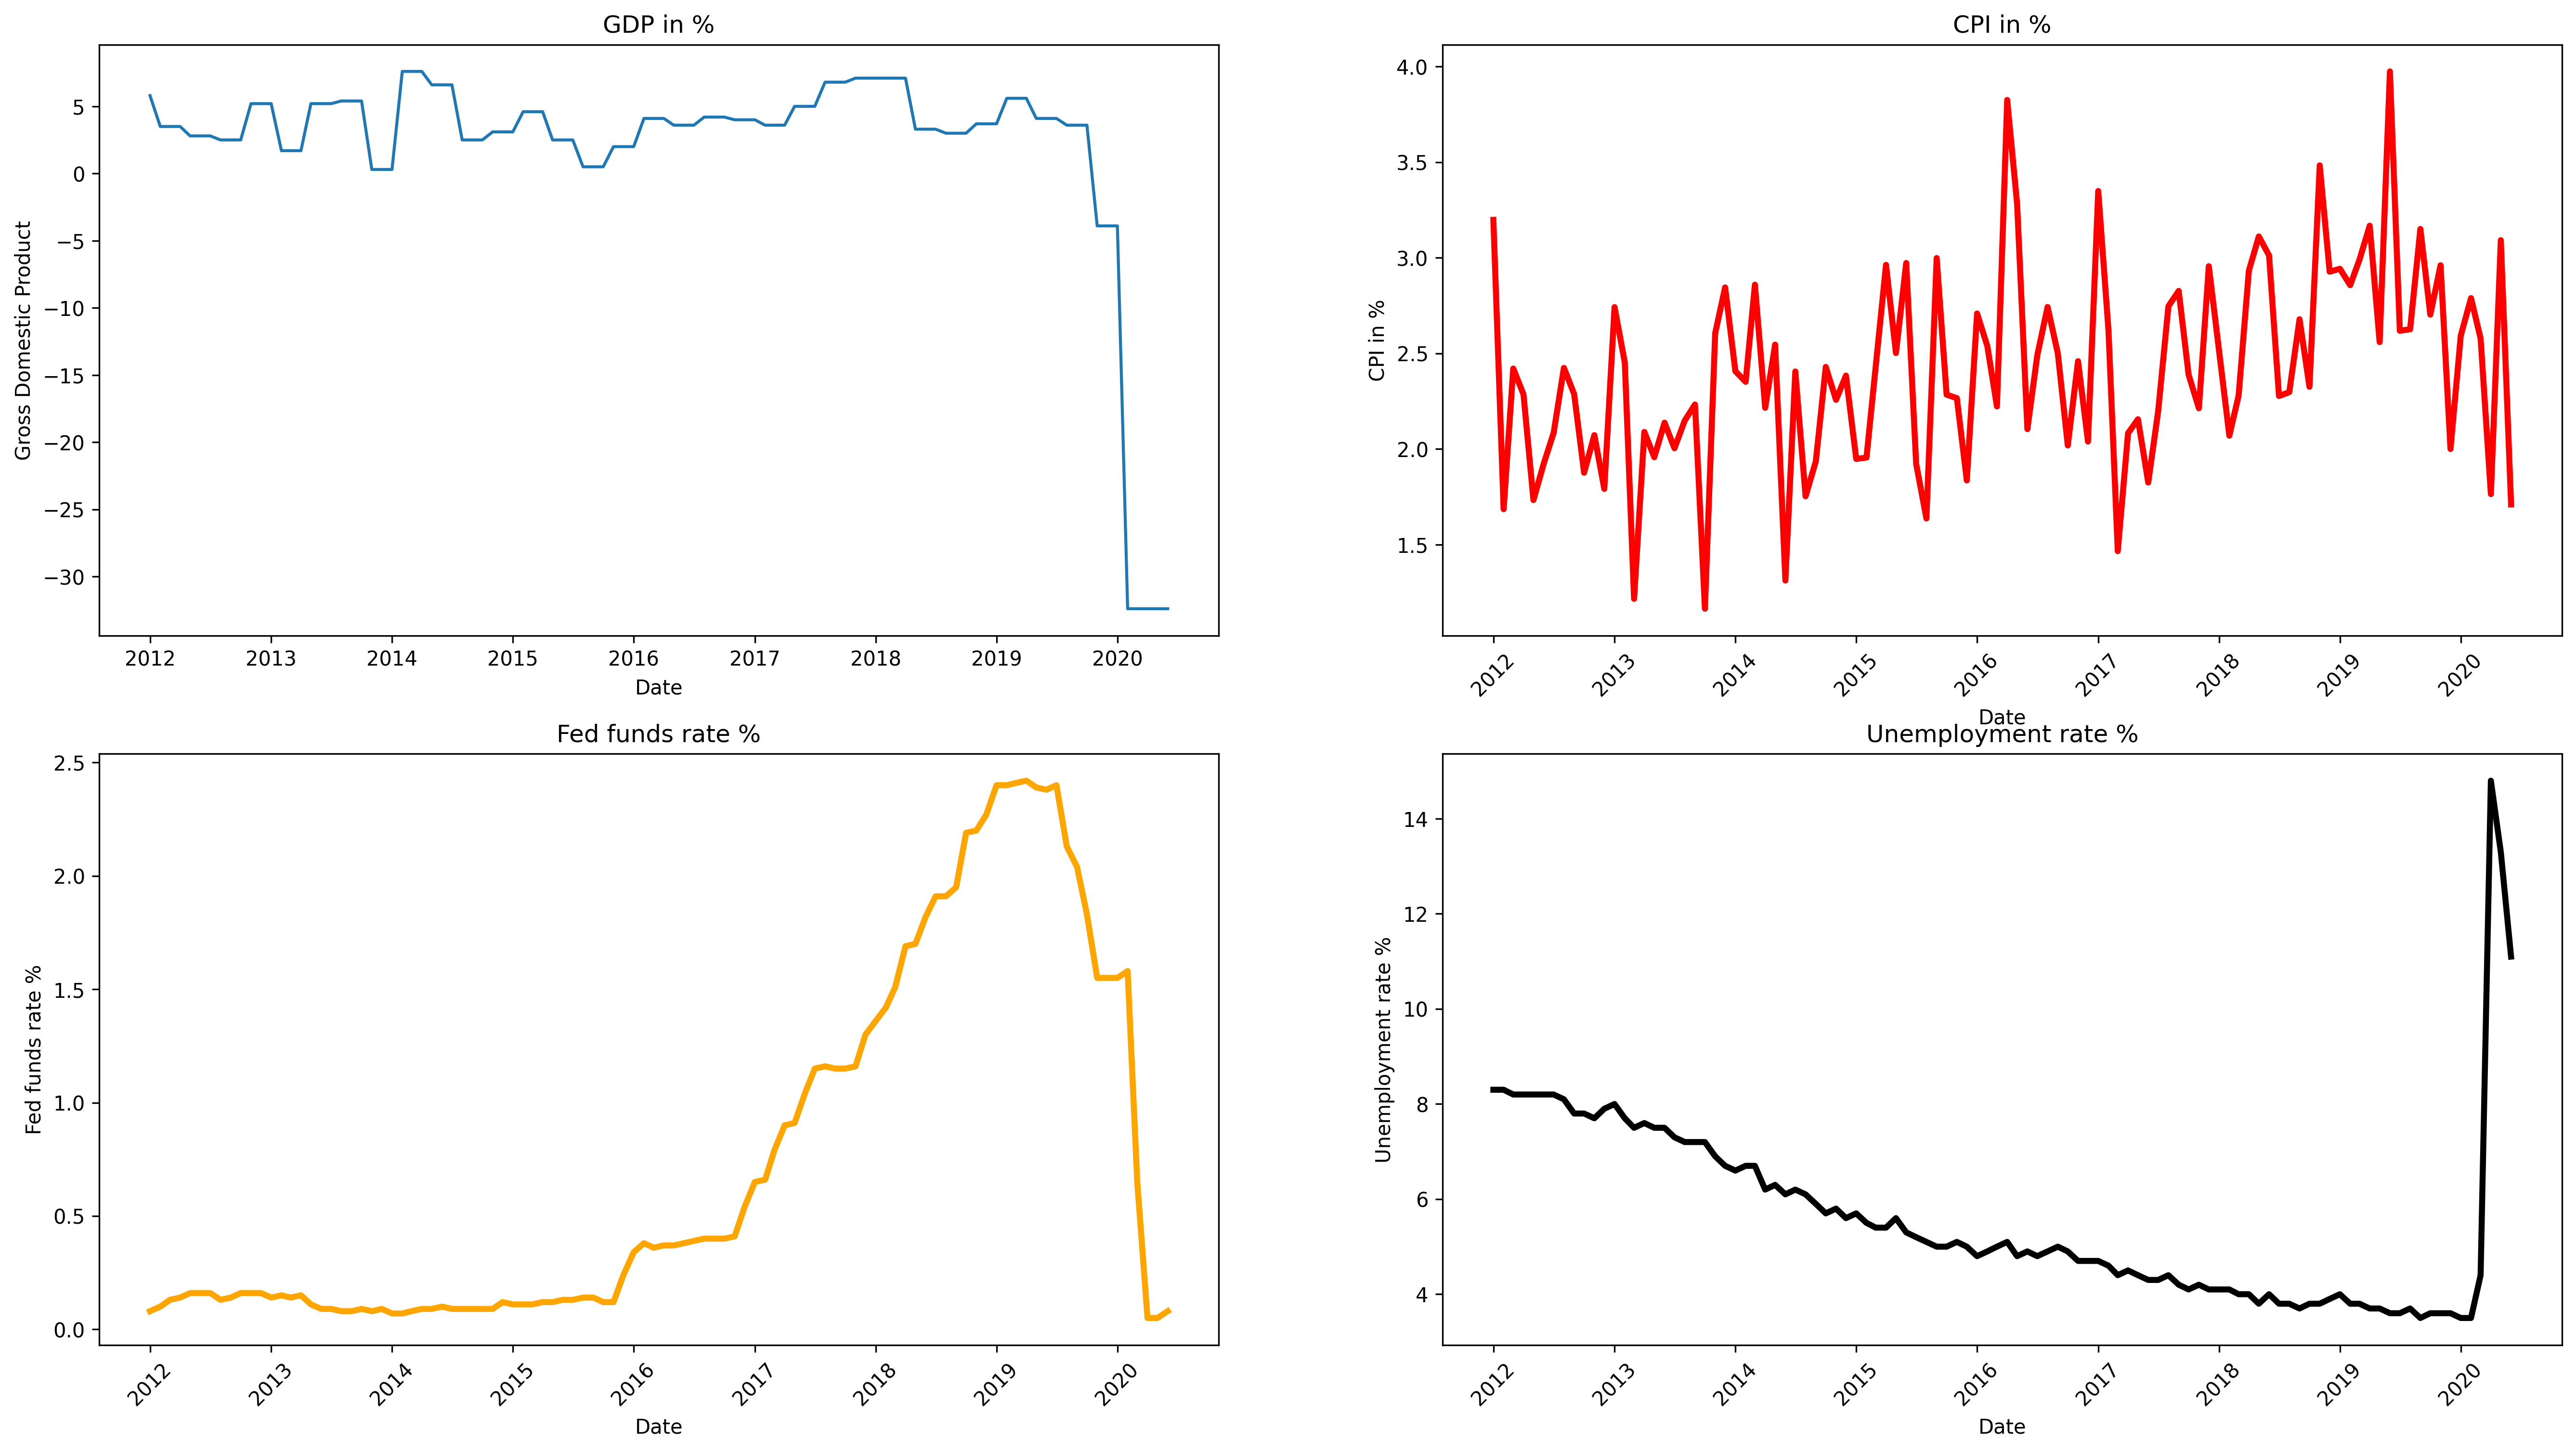

In [270]:
# Line plots
fig1 = plt.figure(figsize=(22, 10),dpi=300)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 1      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
fig1.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

ax1 = fig1.add_subplot(221)
sns.lineplot(
    data=df_merged_clean, 
#     kind="line",
    x=df_merged_clean.index, 
    y="Gross Domestic Product")
plt.xlabel('Date')
plt.title('GDP in %')

ax2 = fig1.add_subplot(222)
sns.lineplot(
    data=df_merged_clean, 
    x=df_merged_clean.index, 
    y="CPI",
    ax = ax2,
    linewidth = 3,
    color = 'red')
plt.xticks(rotation=45) 
plt.ylabel('CPI in %')
plt.xlabel('Date')
plt.title('CPI in %')

ax3 = fig1.add_subplot(223)
sns.lineplot(
    data=df_merged_clean, 
    x=df_merged_clean.index, 
    y="Effective Federal Funds Rate",
    ax = ax3,
    linewidth = 3,
    color = 'orange')
plt.xticks(rotation=45) 
plt.ylabel('Fed funds rate %')
plt.xlabel('Date')
plt.title('Fed funds rate %')

ax4 = fig1.add_subplot(224)
sns.lineplot(
    data=df_merged_clean, 
    x=df_merged_clean.index, 
    y="Unemployment Rate, Percent",
    ax = ax4,
    linewidth = 3,
    color = 'black')
plt.xticks(rotation=45) 
plt.ylabel('Unemployment rate %')
plt.xlabel('Date')
plt.title('Unemployment rate %')


In [271]:
round(df_merged_clean.describe(),2)

,Monthly return,CPI,Effective Federal Funds Rate,"Unemployment Rate, Percent",Gross Domestic Product
count,101.00,101.00,101.00,101.00,101.00
mean,0.02,2.42,0.72,5.65,1.97
std,0.05,0.52,0.80,2.02,8.18
min,-0.16,1.16,0.05,3.50,-32.40
25%,-0.01,2.07,0.11,4.10,2.50
50%,0.02,2.40,0.24,5.00,3.60
75%,0.05,2.75,1.30,6.90,5.20
max,0.16,3.97,2.42,14.80,7.60


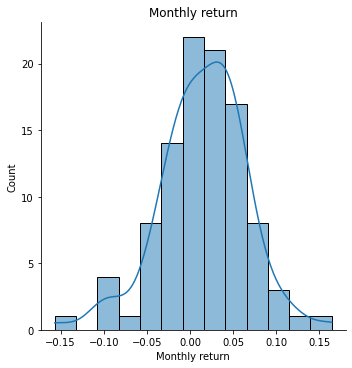

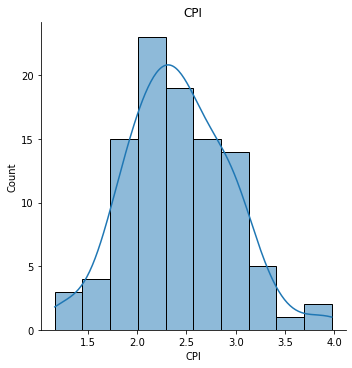

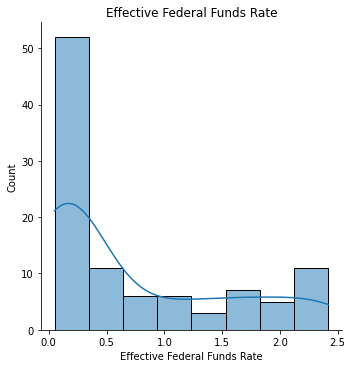

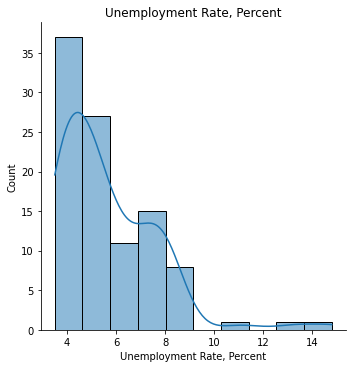

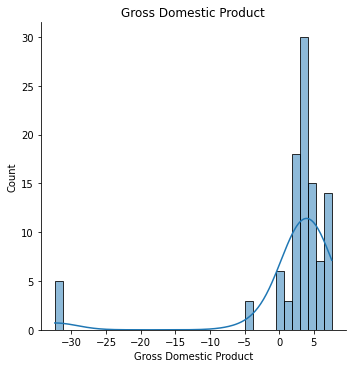

In [272]:
#Visualisation data distribution
for i in df_columns:
  sns.displot(df_merged_clean, x=i,kde=True)
  plt.title(i)

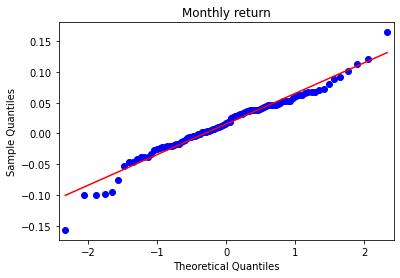

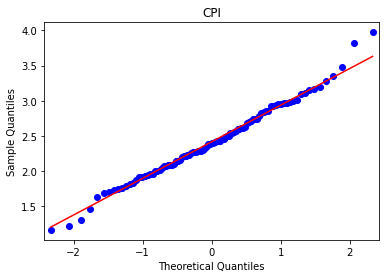

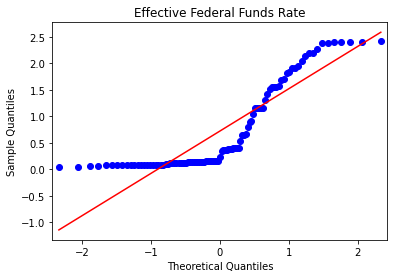

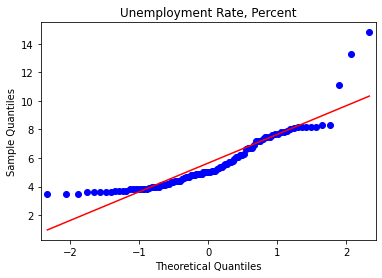

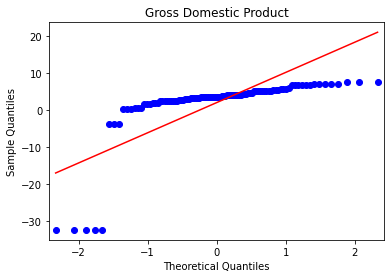

In [273]:
#checking the distribution of a data sample iwiths the quantile-quantile plot, Q-Q plot
for i in df_columns:
  qqplot(df_merged_clean[i], line='s')
  plt.title(i)
  plt.show()


In [274]:
# Anderson Test for Gaussian distribution
for i in df_columns: 
  result = anderson(df_merged_clean[i])
  print(' ')
  print(i + ' Statistic: %.3f' % result.statistic)
  p = 0
  for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
      print(' %.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
      print(' %.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

 
Monthly return Statistic: 0.730
 15.000: 0.555, data does not look normal (reject H0)
 10.000: 0.633, data does not look normal (reject H0)
 5.000: 0.759, data looks normal (fail to reject H0)
 2.500: 0.885, data looks normal (fail to reject H0)
 1.000: 1.053, data looks normal (fail to reject H0)
 
CPI Statistic: 0.222
 15.000: 0.555, data looks normal (fail to reject H0)
 10.000: 0.633, data looks normal (fail to reject H0)
 5.000: 0.759, data looks normal (fail to reject H0)
 2.500: 0.885, data looks normal (fail to reject H0)
 1.000: 1.053, data looks normal (fail to reject H0)
 
Effective Federal Funds Rate Statistic: 9.662
 15.000: 0.555, data does not look normal (reject H0)
 10.000: 0.633, data does not look normal (reject H0)
 5.000: 0.759, data does not look normal (reject H0)
 2.500: 0.885, data does not look normal (reject H0)
 1.000: 1.053, data does not look normal (reject H0)
 
Unemployment Rate, Percent Statistic: 3.493
 15.000: 0.555, data does not look normal (rejec

In [275]:
"""dict = {'Monthly return': 'Monthly return',
        'CPI':'CPI',
        'Effective Federal Funds Rate': 'Interest rates',
        'Unemployment Rate, Percent': 'Uneployment rate',
        'Gross Domestic Product':'GDP'
        }

# call rename () method
df_merged_clean.rename(columns=dict,
          inplace=True)"""

"dict = {'Monthly return': 'Monthly return',\n        'CPI':'CPI',\n        'Effective Federal Funds Rate': 'Interest rates',\n        'Unemployment Rate, Percent': 'Uneployment rate',\n        'Gross Domestic Product':'GDP'\n        }\n\n# call rename () method\ndf_merged_clean.rename(columns=dict,\n          inplace=True)"

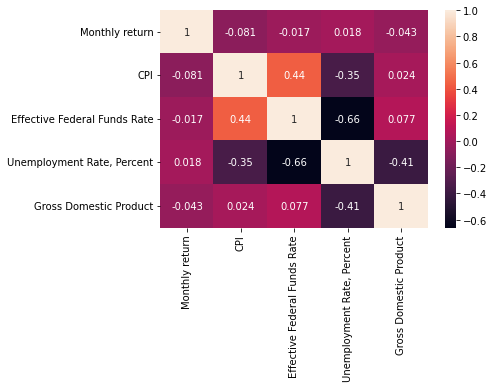

In [276]:
#Create correlation matrix 
corrMatrix = df_merged_clean.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

When dealing with time series data, it is important to examine the existence of unit root in the  data series.  A non-stationary process generates the problem of  spurious regression between unrelated variables. We use the Augmented Dickey-Fuller (ADF) test. 


In [277]:
#Function for the ADF test
def ADF_test(DF,columns):
  #DF = dataframe
  #columns = columns of DF
  for i in columns:
    X = DF[i].values
    result = adfuller(X)
    print(i)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))

#Log function of the ADF test to smooth the data a bit more
def ADF_log_test(DF,columns):
  for i in columns:
    X = DF[i].values
    X = log(X)
    X = X[np.logical_not(np.isnan(X))]
    result = adfuller(X)
    print(i + ' ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))

ADF_log_test(df_merged_clean,df_columns)

Monthly return ADF Statistic: -9.282702
p-value: 0.000000
Critical Values:
	1%: -3.537
	5%: -2.908
	10%: -2.591
CPI ADF Statistic: -3.896469
p-value: 0.002061
Critical Values:
	1%: -3.499
	5%: -2.892
	10%: -2.583
Effective Federal Funds Rate ADF Statistic: -1.175634
p-value: 0.683989
Critical Values:
	1%: -3.499
	5%: -2.892
	10%: -2.583
Unemployment Rate, Percent ADF Statistic: -2.049980
p-value: 0.265098
Critical Values:
	1%: -3.498
	5%: -2.891
	10%: -2.583
Gross Domestic Product ADF Statistic: -2.418748
p-value: 0.136515
Critical Values:
	1%: -3.509
	5%: -2.896
	10%: -2.585


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log


In [278]:
#Once we executed the ADF test, we first difference the independent variables wehere the time series is non-stationary
columns = ['Effective Federal Funds Rate','Unemployment Rate, Percent'	,'Gross Domestic Product']
df_merged_clean_first_difference = df_merged_clean[columns].diff().dropna()
df_columns_first_difference = df_merged_clean_first_difference.columns

ADF_test(df_merged_clean_first_difference,df_columns_first_difference)

Effective Federal Funds Rate
ADF Statistic: 0.354891
p-value: 0.979727
Critical Values:
	1%: -3.506
	5%: -2.895
	10%: -2.584
Unemployment Rate, Percent
ADF Statistic: -8.433227
p-value: 0.000000
Critical Values:
	1%: -3.499
	5%: -2.892
	10%: -2.583
Gross Domestic Product
ADF Statistic: -9.999045
p-value: 0.000000
Critical Values:
	1%: -3.498
	5%: -2.891
	10%: -2.583


Text(0.5, 1.0, 'Unemployment rate %')

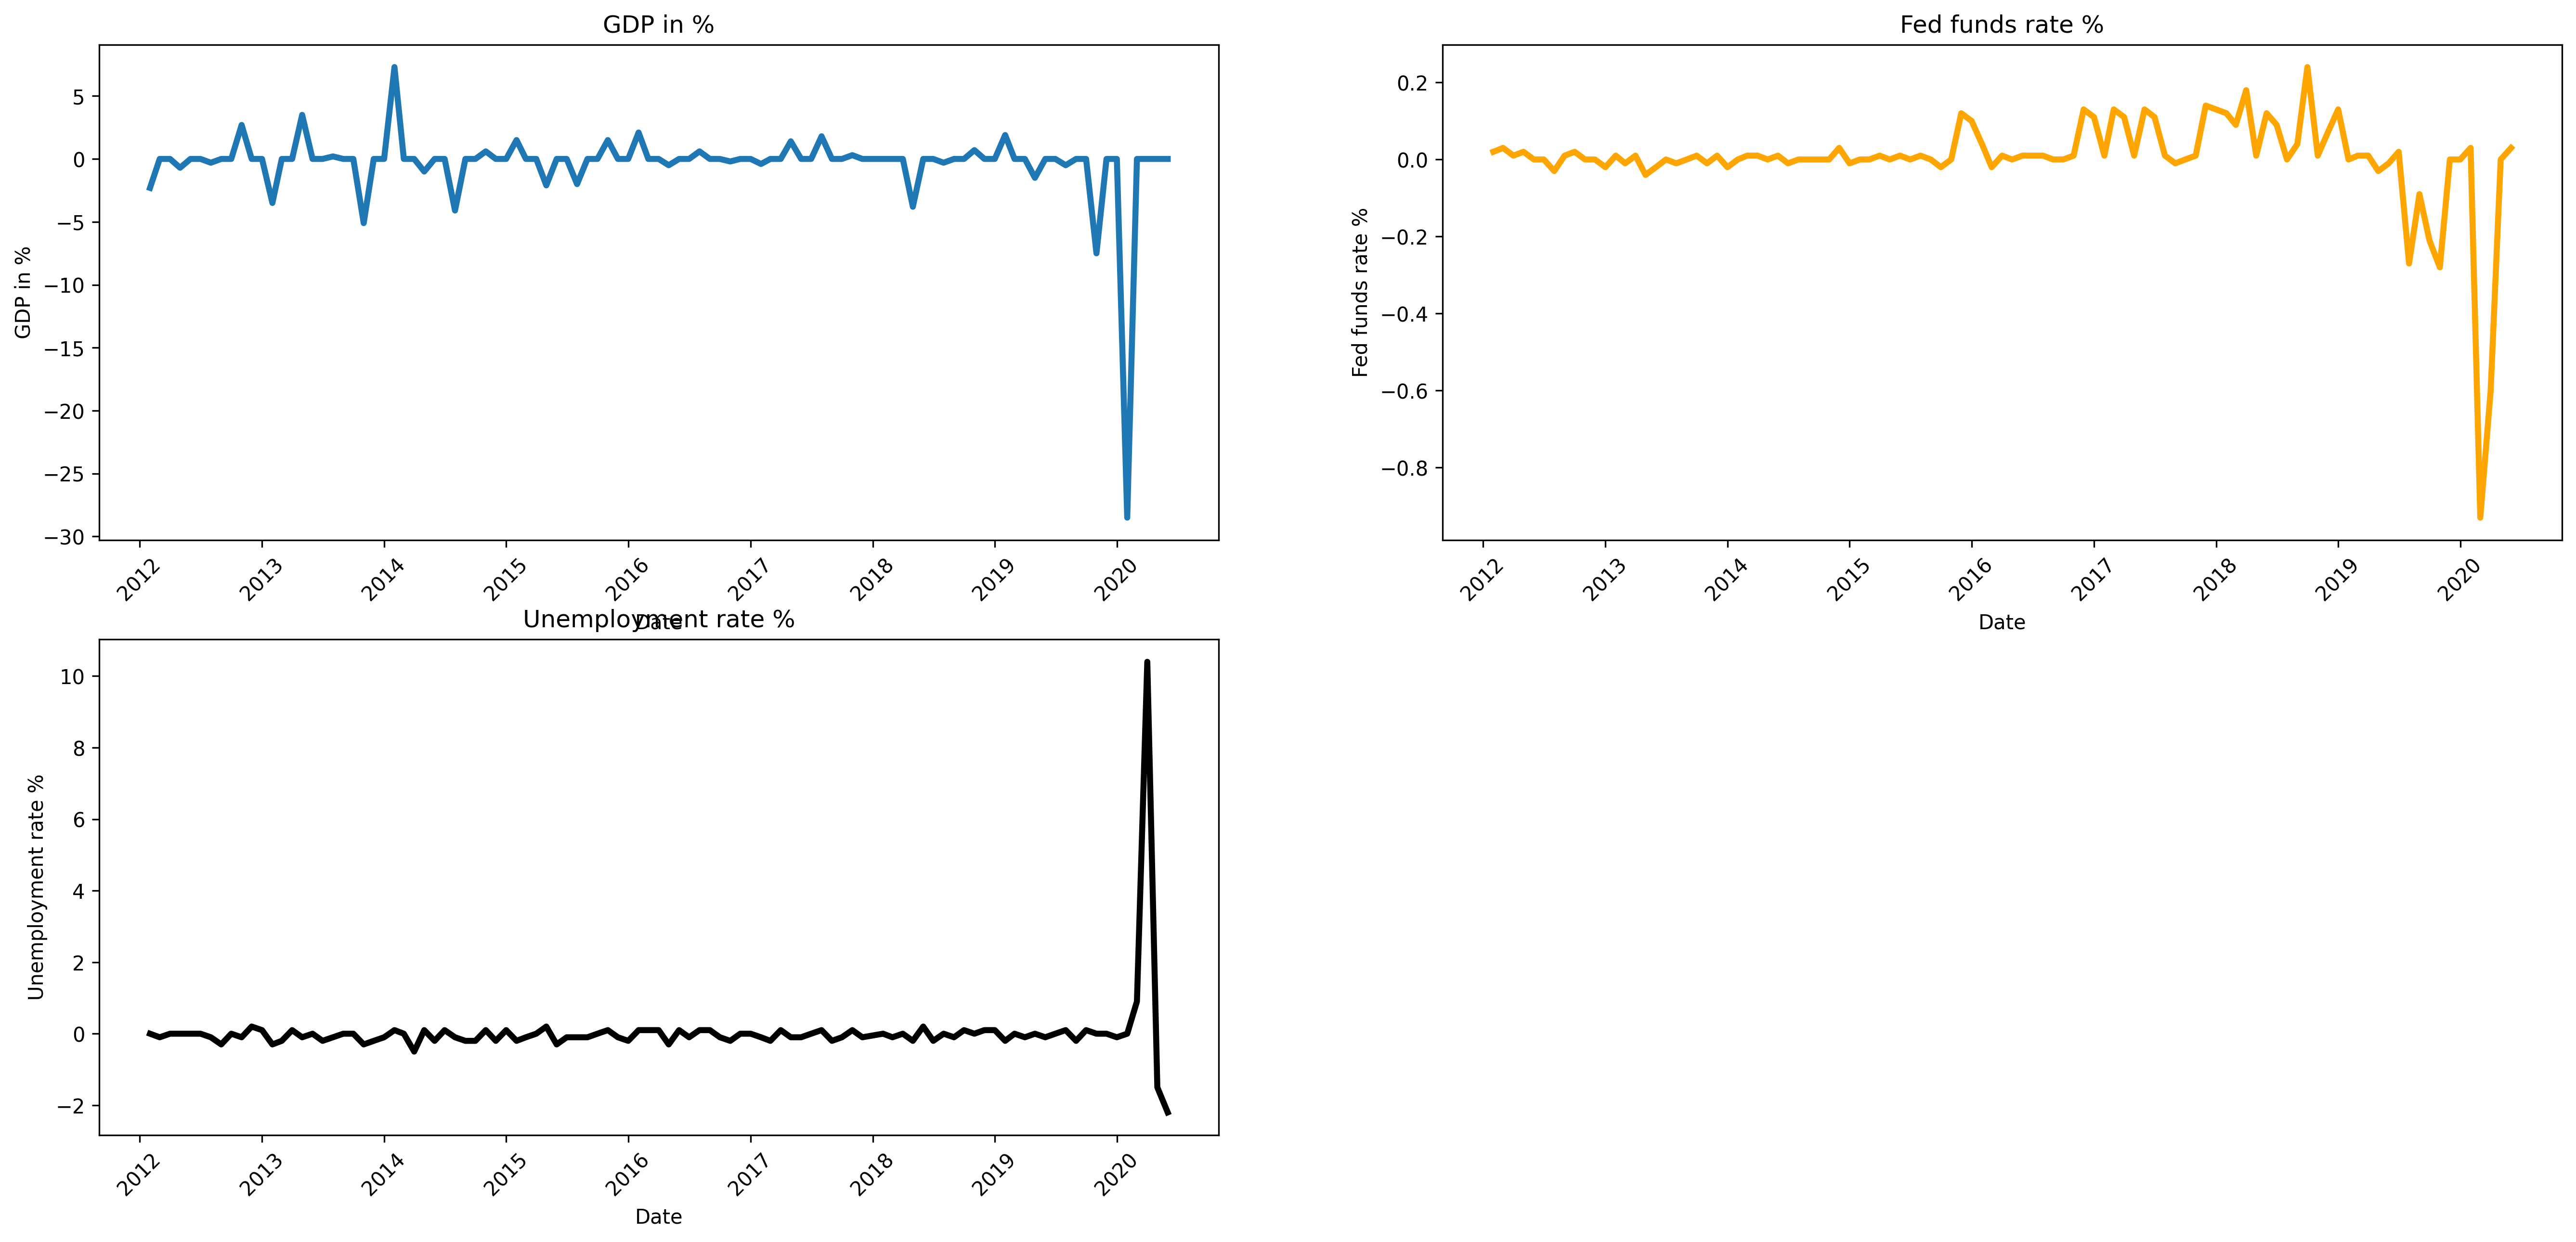

In [279]:
# Line plots
fig2 = plt.figure(figsize=(22, 10),dpi=300)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 1      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
fig1.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

ax1 = fig2.add_subplot(221)
sns.lineplot(
    data=df_merged_clean_first_difference, 
#     kind="line",
    x=df_merged_clean_first_difference.index, 
    y="Gross Domestic Product",
    ax = ax1,
    linewidth = 3)
plt.xticks(rotation=45) 
plt.ylabel('GDP in %')
plt.xlabel('Date')
plt.title('GDP in %')

ax2 = fig2.add_subplot(222)
sns.lineplot(
    data=df_merged_clean_first_difference, 
    x=df_merged_clean_first_difference.index, 
    y="Effective Federal Funds Rate",
    ax = ax2,
    linewidth = 3,
    color = 'orange')
plt.xticks(rotation=45) 
plt.ylabel('Fed funds rate %')
plt.xlabel('Date')
plt.title('Fed funds rate %')

ax3 = fig2.add_subplot(223)
sns.lineplot(
    data=df_merged_clean_first_difference, 
    x=df_merged_clean_first_difference.index, 
    y="Unemployment Rate, Percent",
    ax = ax3,
    linewidth = 3,
    color = 'black')
plt.xticks(rotation=45) 
plt.ylabel('Unemployment rate %')
plt.xlabel('Date')
plt.title('Unemployment rate %')


In [280]:
#We re-do the same and look for the second difference for the independent variables still non-stationary even after first-difference
columns_second = ['Unemployment Rate, Percent','Effective Federal Funds Rate']
df_merged_clean_second_difference = df_merged_clean_first_difference[columns_second].diff().dropna()
df_columns_second_difference = df_merged_clean_second_difference.columns
ADF_test(df_merged_clean_second_difference,df_columns_second_difference)

Unemployment Rate, Percent
ADF Statistic: -7.762476
p-value: 0.000000
Critical Values:
	1%: -3.500
	5%: -2.892
	10%: -2.583
Effective Federal Funds Rate
ADF Statistic: -2.211828
p-value: 0.201981
Critical Values:
	1%: -3.506
	5%: -2.895
	10%: -2.584


Text(0.5, 1.0, 'Unemployment rate %')

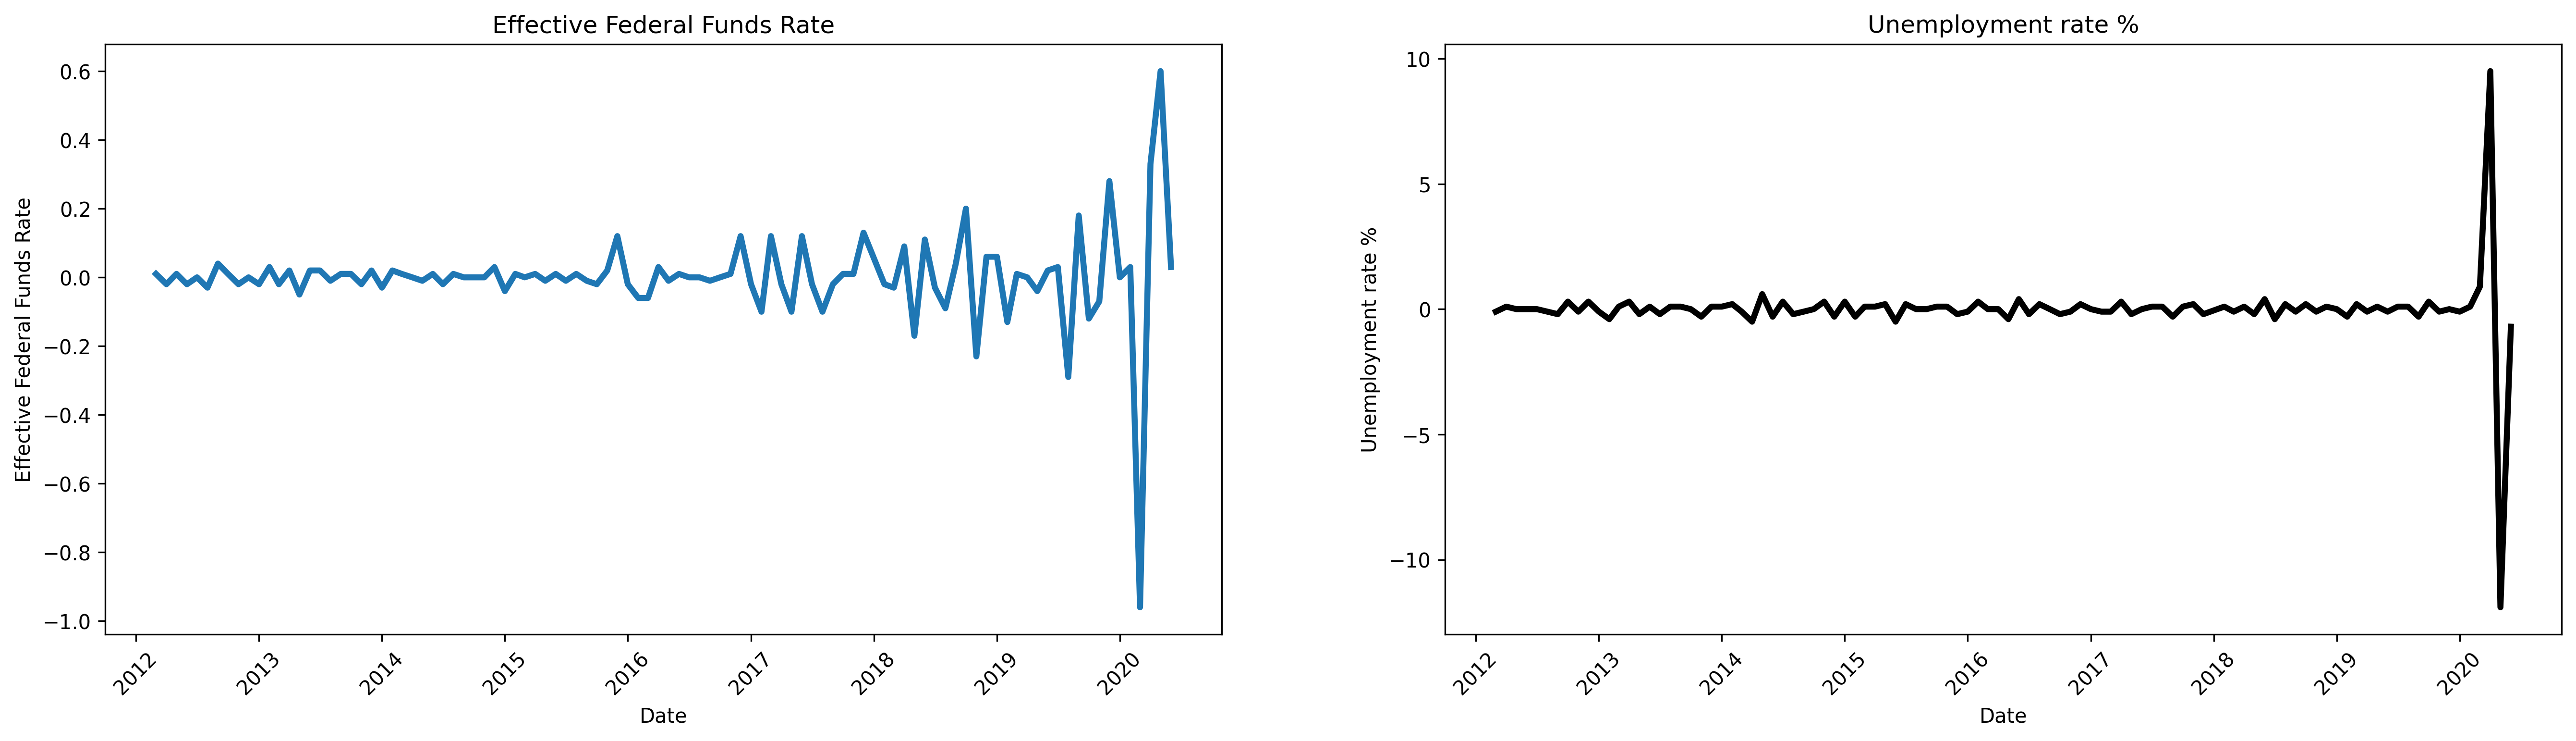

In [281]:
# Line plots
fig3 = plt.figure(figsize=(22, 10),dpi=300)
fig3.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

ax1 = fig3.add_subplot(221)
sns.lineplot(
    data=df_merged_clean_second_difference, 
#     kind="line",
    x=df_merged_clean_second_difference.index, 
    y="Effective Federal Funds Rate",
    ax = ax1,
    linewidth = 3)
plt.xticks(rotation=45) 
plt.ylabel('Effective Federal Funds Rate')
plt.xlabel('Date')
plt.title('Effective Federal Funds Rate')

ax2 = fig3.add_subplot(222)
sns.lineplot(
    data=df_merged_clean_second_difference, 
    x=df_merged_clean_second_difference.index, 
    y="Unemployment Rate, Percent",
    ax = ax2,
    linewidth = 3,
    color = 'black')
plt.xticks(rotation=45) 
plt.ylabel('Unemployment rate %')
plt.xlabel('Date')
plt.title('Unemployment rate %')

In [282]:
#We re-do the same and look for the second difference for the independent variables still non-stationary even after first-difference
columns_third = ['Effective Federal Funds Rate']
df_merged_clean_third_difference = df_merged_clean_second_difference[columns_third].diff().dropna()
df_columns_third_difference = df_merged_clean_third_difference.columns
ADF_test(df_merged_clean_third_difference,df_columns_third_difference)

Effective Federal Funds Rate
ADF Statistic: -9.317709
p-value: 0.000000
Critical Values:
	1%: -3.505
	5%: -2.894
	10%: -2.584


Text(0.5, 1.0, 'Effective Federal Funds Rate')

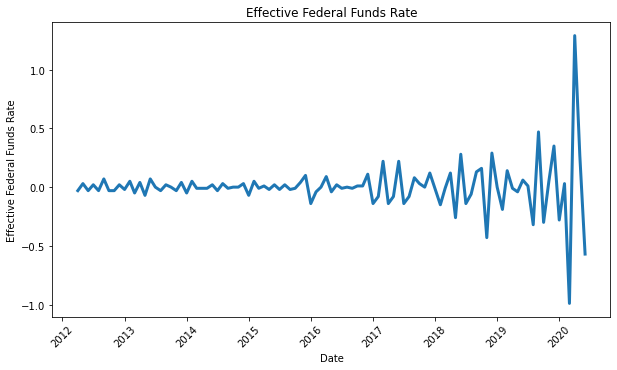

In [283]:
# Line plots
fig4 = plt.figure(figsize=(22, 10))
fig4.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

ax1 = fig4.add_subplot(221)
sns.lineplot(
    data=df_merged_clean_third_difference, 
#     kind="line",
    x=df_merged_clean_third_difference.index, 
    y="Effective Federal Funds Rate",
    ax = ax1,
    linewidth = 3)
plt.xticks(rotation=45) 
plt.ylabel('Effective Federal Funds Rate')
plt.xlabel('Date')
plt.title('Effective Federal Funds Rate')

In [284]:
#We select the columns where we executed the first & second difference
selected_first = df_merged_clean[['Monthly return','CPI']]
selected_second  = df_merged_clean_first_difference[['Gross Domestic Product']]
selected_third = df_merged_clean_second_difference[['Unemployment Rate, Percent']]
data_frames_ = [df_merged_clean_third_difference,selected_first,selected_second,selected_third]

#Merge all DF into one based on "observation date" using the function melt, keep N/A if any

df_total = reduce(lambda  left,right: pd.merge(left,right,on=['observation_date'],
                                            how='left'), data_frames_)
columns_ = ['CPI','Effective Federal Funds Rate','Unemployment Rate, Percent','Gross Domestic Product']

In [285]:
#We execute the OLS analysis. After the difference modifications (firs/second differences) our OLS model is as followed:
#(Nasdaq Monthly Return)t = α1 + β1*(CPI)t + β2FD* (Effective fund rates)t + β3FD2 *(Unemployment)t + β4FD2 * (GDP)t
#FD = First difference
#FD2 = Second difference
x = df_total[columns_]
Y = df_total['Monthly return']
model = sm.OLS(Y, x)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:         Monthly return   R-squared (uncentered):                   0.265
Model:                            OLS   Adj. R-squared (uncentered):              0.233
Method:                 Least Squares   F-statistic:                              8.461
Date:                Fri, 01 Oct 2021   Prob (F-statistic):                    7.10e-06
Time:                        09:32:36   Log-Likelihood:                          166.47
No. Observations:                  98   AIC:                                     -324.9
Df Residuals:                      94   BIC:                                     -314.6
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

In [286]:
maxlag=1
test = 'ssr_chi2test'
'https://stackoverflow.com/questions/58005681/is-it-possible-to-run-a-vector-autoregression-analysis-on-a-large-gdp-data-with'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_total, variables = df_total.columns)


,Effective Federal Funds Rate_x,Monthly return_x,CPI_x,Gross Domestic Product_x,"Unemployment Rate, Percent_x"
Effective Federal Funds Rate_y,1.0000,0.0170,0.4763,0.0000,0.0000
Monthly return_y,0.0011,1.0000,0.3750,0.3317,0.4263
CPI_y,0.2360,0.4062,1.0000,0.9426,0.0178
Gross Domestic Product_y,0.1633,0.2103,0.5979,1.0000,0.9601
"Unemployment Rate, Percent_y",0.0000,0.9824,0.7074,0.5630,1.0000


In [287]:
for i in columns_:
  df_total['Shift ' + i] = df_total[i].shift(4)
column_shift = ['Shift CPI',	'Shift Effective Federal Funds Rate',	'Shift Unemployment Rate, Percent','Shift Gross Domestic Product']
df_total = df_total.dropna()

In [288]:
#We execute the OLS analysis. After the difference modifications (firs/second differences) our OLS model is as followed:
#(Nasdaq Monthly Return)t = α1 + β1*(CPI)t + β2FD* (Effective fund rates)t + β3FD2 *(Unemployment)t + β4FD2 * (GDP)t
#FD = First difference
#FD2 = Second difference
x = df_total[column_shift]
Y = df_total['Monthly return']
model = sm.OLS(Y, x)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:         Monthly return   R-squared (uncentered):                   0.165
Model:                            OLS   Adj. R-squared (uncentered):              0.127
Method:                 Least Squares   F-statistic:                              4.433
Date:                Fri, 01 Oct 2021   Prob (F-statistic):                     0.00257
Time:                        09:32:36   Log-Likelihood:                          154.97
No. Observations:                  94   AIC:                                     -301.9
Df Residuals:                      90   BIC:                                     -291.8
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------